In [1]:
import os

datapath = os.getcwd()+'\\data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TrainData = pd.read_csv(datapath + '\\train.csv')
ValData = pd.read_csv(datapath + '\\val.csv')
TestData = pd.read_csv(datapath + '\\test.csv')

In [4]:
import math

root = len(TrainData.drop(columns=['ID']).columns)**0.5
nrows = math.floor(root)
ncols = math.ceil(root)

arr = np.ones((nrows, ncols))

-----------------------------------------------

Train/val 정상 분포 확인

0.11.2


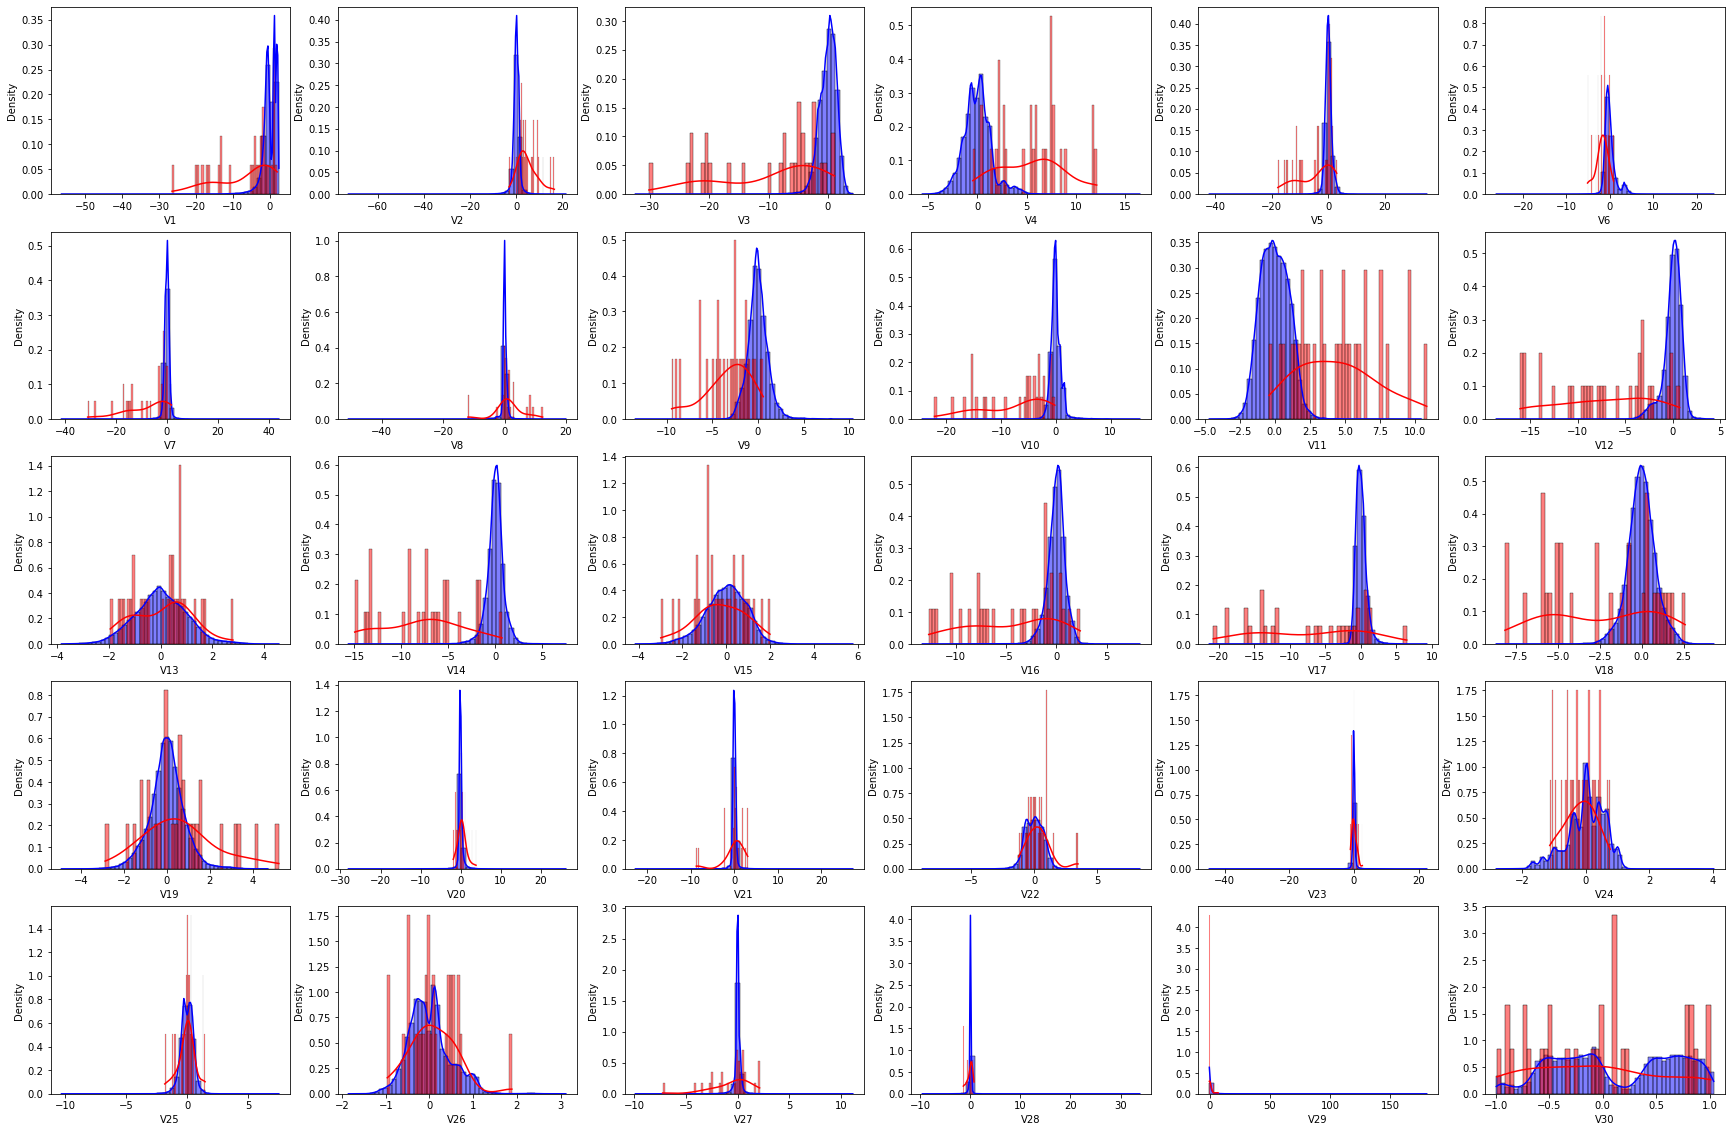

In [6]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

print(sns.__version__)

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.histplot(TrainData[col],ax = axes[i,j], stat = 'density', bins= 50, color = 'blue',kde=True, kde_kws = {'bw_adjust': 1})
    sns.histplot(ValData[ValData['Class']==1][col],ax = axes[i,j], stat = 'density', bins= 50, color = 'red',kde=True, kde_kws = {'bw_adjust': 1})
                 
plt.show()

사기탐지됨 플롯의 확률 밀도를 가져와보자

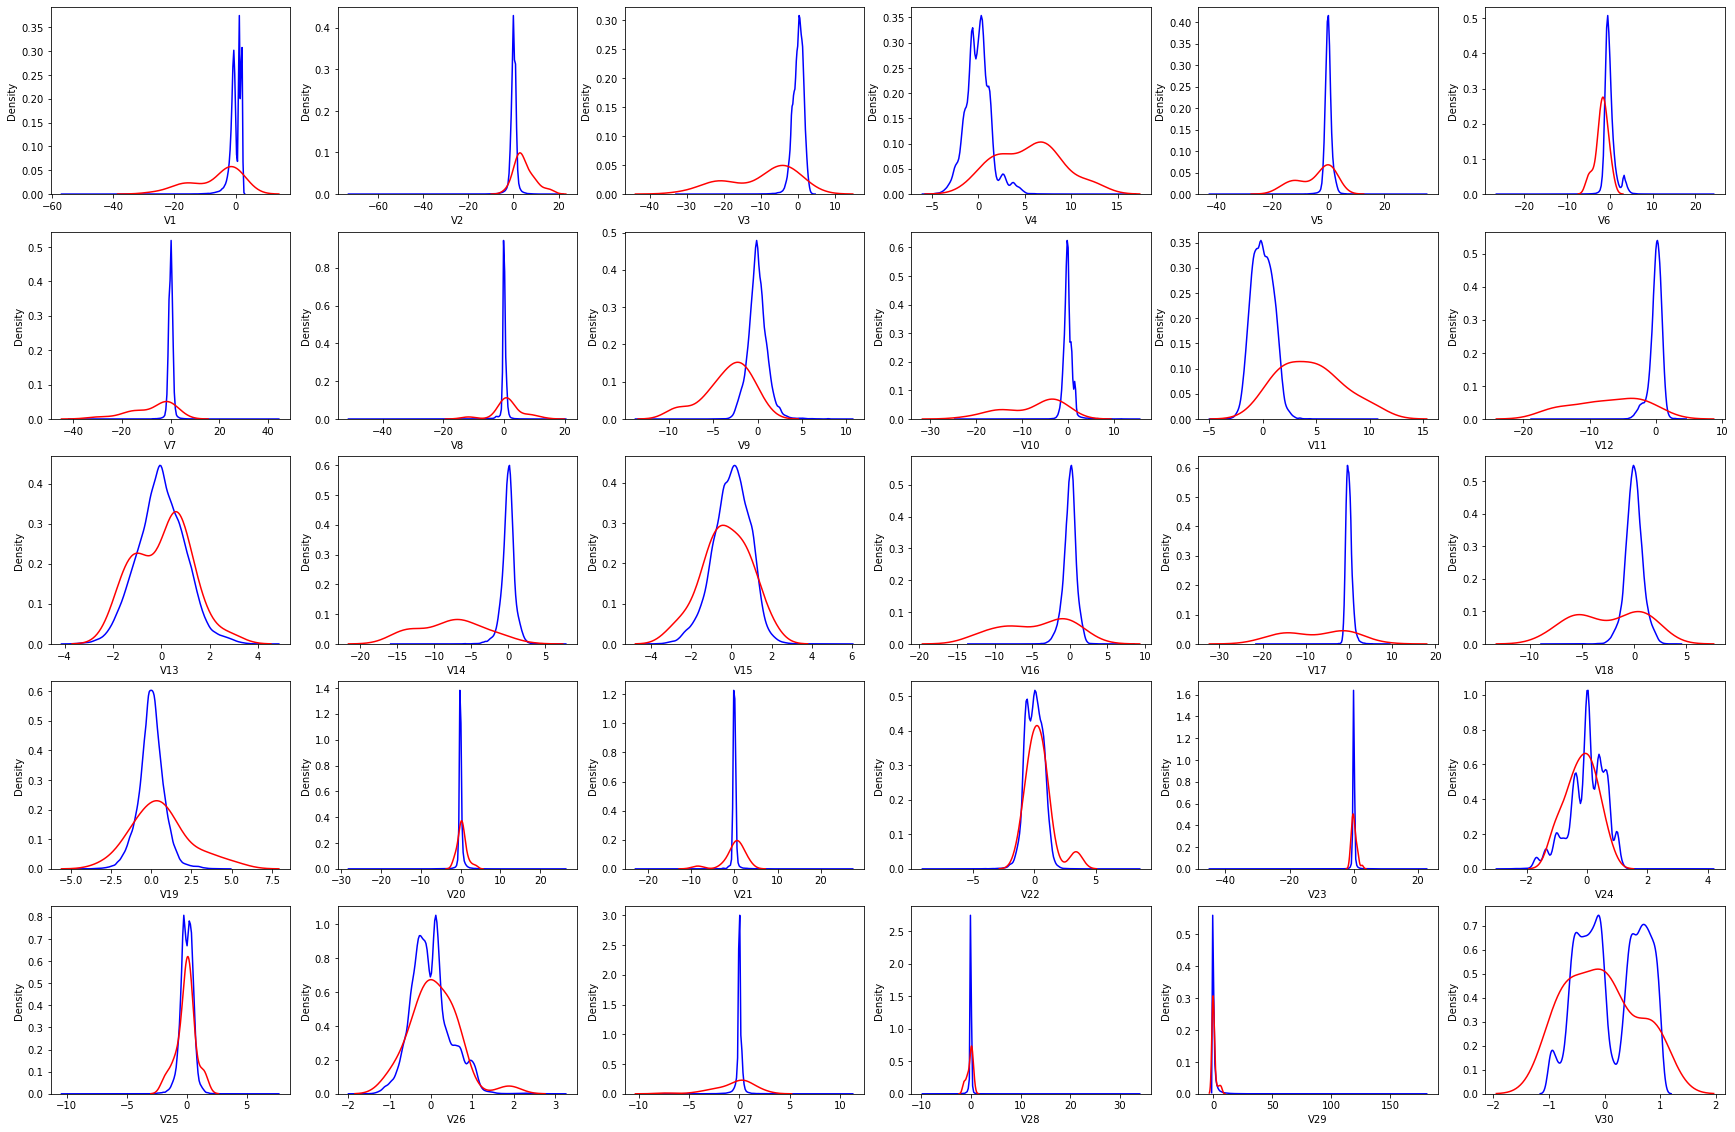

In [6]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
    sns.kdeplot(ValData[ValData['Class']==1][col],ax = axes[i,j], color = 'red')
                 
plt.show()

-----------------------------------------------

Isolation 사기탐지 모델

In [66]:
val_normal, val_fraud = ValData['Class'].value_counts()
val_contamination = val_fraud / len(ValData)

print('prob :',val_contamination)

prob : 0.0010540369615627855


In [67]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

train_x = TrainData.drop(columns=['ID'])

model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination=val_contamination, random_state=42, verbose=0)
model.fit(train_x)

IsolationForest(contamination=0.0010540369615627855, max_samples=113842,
                n_estimators=125, random_state=42)

In [68]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [69]:
val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.7030820840915222]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.41      0.40      0.41        30

    accuracy                           1.00     28462
   macro avg       0.71      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



In [70]:
val_pred_df = pd.DataFrame(val_pred,columns=['pred'])
check = pd.concat([val_y,val_pred_df],axis=1)
Id_check = pd.concat([ValData['ID'], check],axis=1)

check[check['Class']==1].sum()

Class    30
pred     12
dtype: int64

In [5]:
# i = []
# j = []

# for (row,col),x in np.ndenumerate(arr) :
#     i = i + [row]
#     j = j + [col]

# #확률밀도비교
# #sharex (True일 경우 X축 공유)
# import seaborn as sns

# f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

# for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
#     sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
#     sns.kdeplot(ValData[ValData['Class']==0][col],ax = axes[i,j], color = 'red')
                 
# plt.show()

In [9]:
#scipy.stats.gaussian_kde 커널을 찾는자

# https://stackoverflow.com/questions/68396403/kernel-density-estimation-using-scipys-gaussian-kde-and-sklearns-kerneldensity
#from scipy.stats import gaussian_kde

# eval_points = np.linspace(np.min(x), np.max(x))
# kde_sp = gaussian_kde(x, bw_method=0.25)
# y_sp = kde_sp.pdf(eval_points)

In [11]:
# from scipy.stats import gaussian_kde

# v1_data = ValData[ValData['Class']==1]['V3']

# kde_sp = gaussian_kde(v1_data,bw_method=0.16) #'silverman' #0.16이 가장 괜찮음
# print(kde_sp.factor)
# #최적 bw = 1.06*std*(n)**(-0.2) #siverman은 아님

# eval_points = np.linspace(np.min(v1_data), np.max(v1_data))

# print([kde_sp.integrate_box_1d(-np.Inf,x) for x in eval_points][-1]) #cdf 마지막 값

# plt.plot(eval_points, kde_sp.pdf(eval_points))

0.16
0.9586228821400884


-----------------------------------------------

KDE 기반 사기탐지

In [5]:
from scipy.stats import gaussian_kde

#고장 KDE

cols = TrainData.columns[1:]

train_pdf = pd.DataFrame()

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(TrainData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    train_pdf = pd.concat([train_pdf,pdf_V], axis = 1)
    

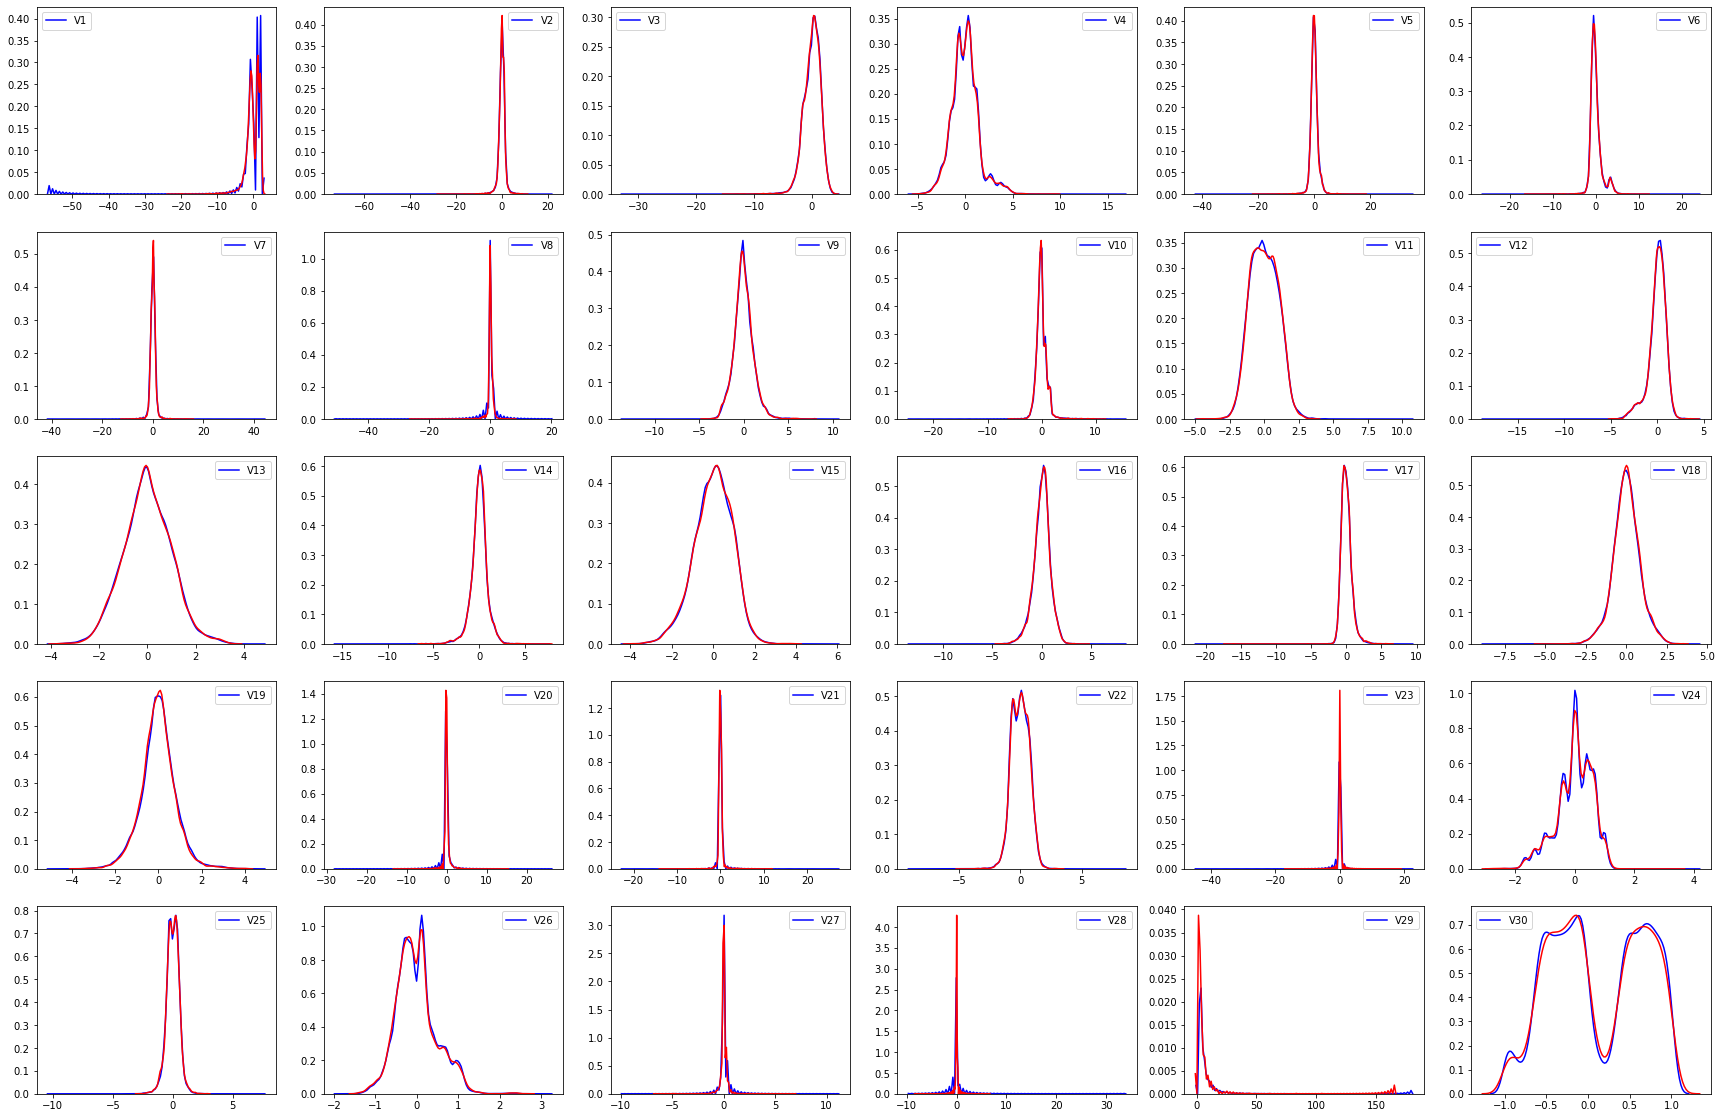

In [77]:
# i = []
# j = []

# for (row,col),x in np.ndenumerate(arr) :
#     i = i + [row]
#     j = j + [col]

# #확률밀도비교
# #sharex (True일 경우 X축 공유)
# import seaborn as sns

# f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

# for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
#     v_data = ValData[ValData['Class']==0][col]
#     kde_sp = gaussian_kde(v_data,bw_method=0.04)
      
#     sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
#     sns.kdeplot(np.array(kde_sp.resample(10000)[0]), bw='silverman', ax = axes[i,j], color = 'red')
    
# plt.show()

In [6]:
train_pdf_zero = pd.DataFrame()

#사기가 아닐 KDF

for col in cols :
    v_data = ValData[ValData['Class']==0][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.04)
    re_sp = gaussian_kde(kde_sp.resample(10000),bw_method='silverman')
    
    pdf_V = re_sp.pdf(TrainData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    train_pdf_zero = pd.concat([train_pdf_zero,pdf_V], axis = 1)

KeyboardInterrupt: 

In [7]:
val_pdf = pd.DataFrame() 

#사기일 KDF

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(ValData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    val_pdf = pd.concat([val_pdf,pdf_V], axis = 1)

In [8]:
val_pdf_zero = pd.DataFrame()

#사기가 아닐 KDF

for col in cols :
    v_data = ValData[ValData['Class']==0][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(ValData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    val_pdf_zero = pd.concat([val_pdf_zero,pdf_V], axis = 1)

-----------------------------------------------

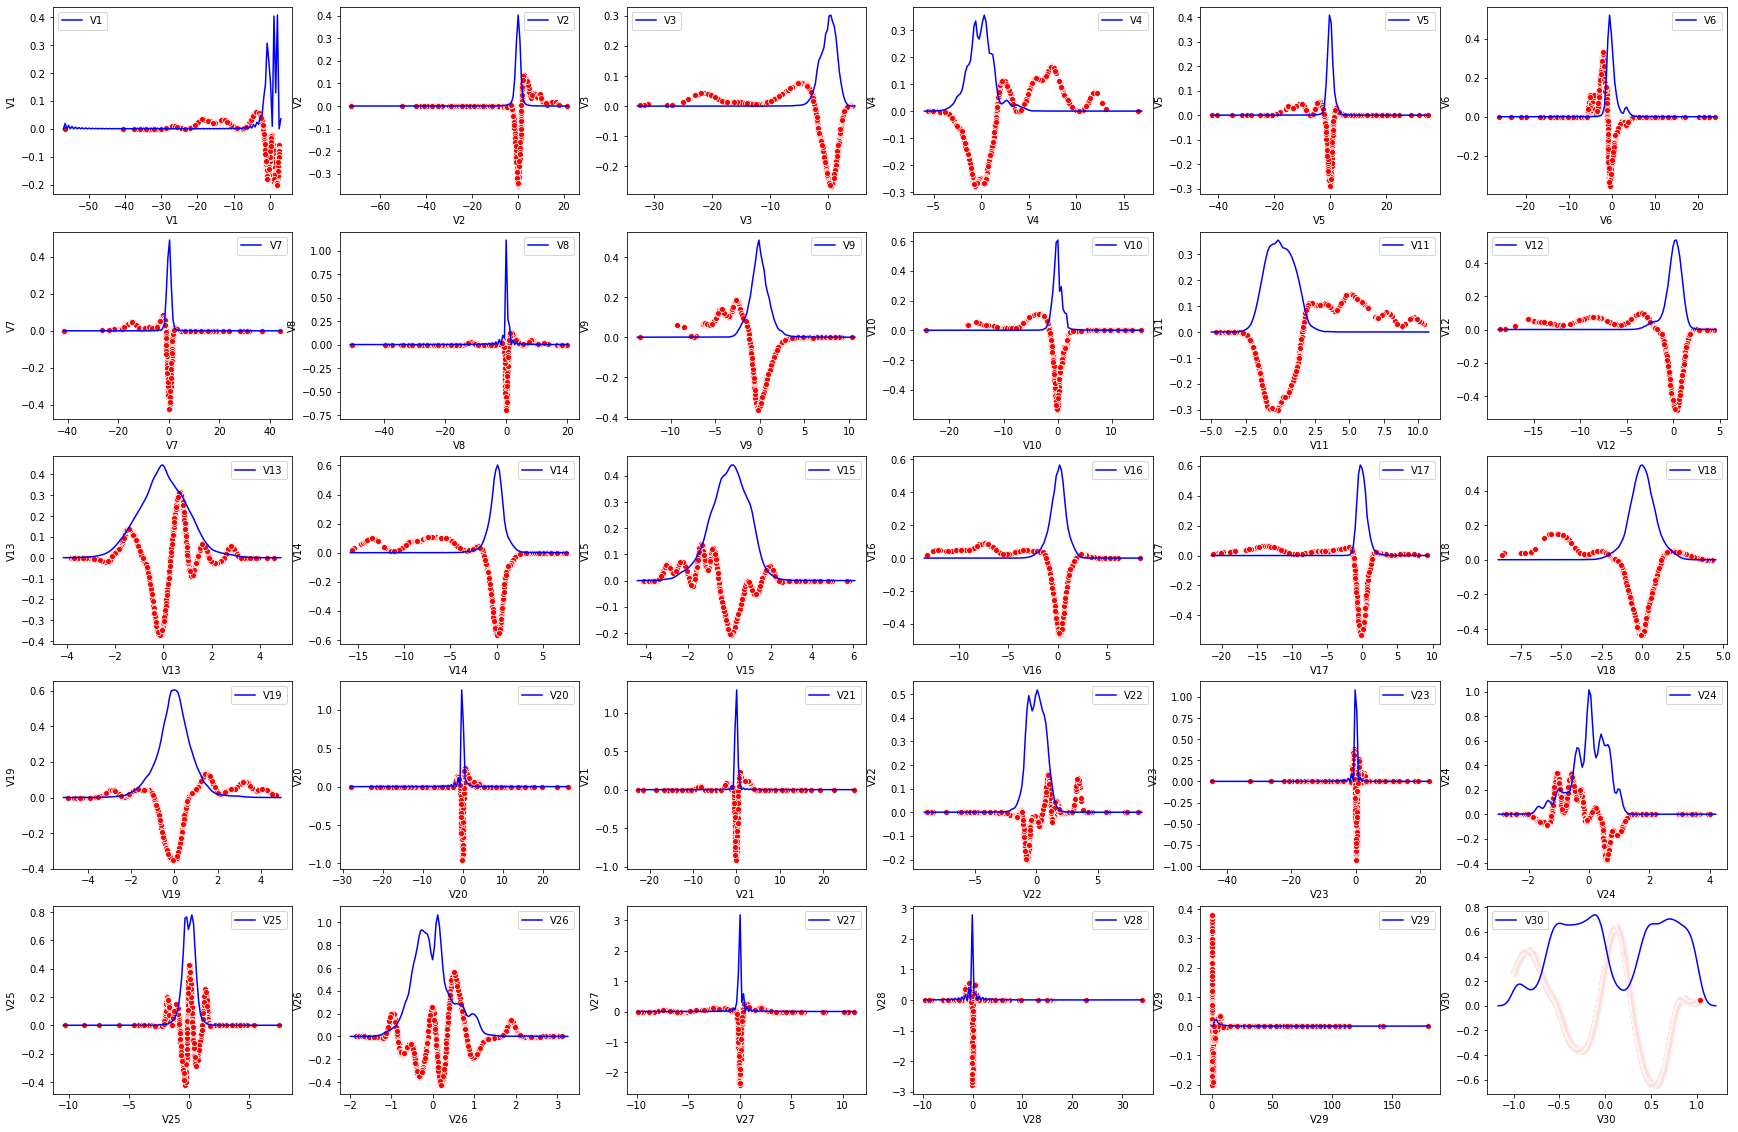

In [7]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
    sns.scatterplot(x=TrainData[col],y=train_pdf[col]-train_pdf_zero[col], ax = axes[i,j], color = 'red')
                 
plt.show()

In [9]:
# mult_vpdf= val_pdf.T.prod()*10**19

score = val_pdf-val_pdf_zero
#score[score<=0]=0 #sum
#score[score<=0]=1 #prod

v_score = score.T.sum()

KDE 검증

In [10]:
v_score = pd.DataFrame(v_score,columns=['score'])
score_class = pd.concat([ValData,v_score],axis=1)

score_class = score_class.sort_values(by='score', ascending=False).reset_index(drop=True)

faud_ID = score_class['ID'][:30]

id_ind =[]

for fid in faud_ID :
    id_ind = id_ind + list(ValData[ValData['ID'] == fid].index)


val_pred = np.zeros(len(ValData))
val_pred[id_ind] = 1


val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#val_pred = model.predict(val_x) # model prediction
#val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.7997889701744514]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.60      0.60      0.60        30

    accuracy                           1.00     28462
   macro avg       0.80      0.80      0.80     28462
weighted avg       1.00      1.00      1.00     28462



In [19]:
val_pred_df = pd.DataFrame(val_pred,columns=['pred'])
check = pd.concat([ValData[['ID','Class']],val_pred_df],axis=1)

In [26]:
check[(check['pred']==1)&(check['Class']==1)]

,ID,Class,pred
641,6339,1,1.0
677,6642,1,1.0
836,8336,1,1.0
1196,12071,1,1.0
1201,12109,1,1.0
1547,15167,1,1.0
3055,30443,1,1.0
4267,42959,1,1.0
4396,44224,1,1.0
7702,77388,1,1.0


-----------------------------------------------

In [71]:
score = train_pdf-train_pdf_zero
v_score = score.T.sum()

In [72]:
TrainData.drop(columns=['ID'])

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [73]:
v_score

0         -7.295899
1         -9.422916
2         -9.543743
3         -4.681324
4         -9.783498
            ...    
113837    -0.380598
113838   -12.822416
113839    -9.888630
113840    -9.511697
113841     0.161380
Length: 113842, dtype: float64

In [74]:
from lightgbm import LGBMRegressor

X_train = TrainData.drop(columns=['ID'])
y_train = v_score

model = LGBMRegressor(learning_rate=0.05)
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05)

In [75]:
val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

val_pred = model.predict(val_x) # model prediction

In [76]:
val_pred

array([ -7.65156467, -10.61224179, -11.95322429, ...,  -5.01227449,
       -11.2933353 ,  -6.76505066])

In [78]:
v_score = pd.DataFrame(val_pred,columns=['score'])
score_class = pd.concat([ValData,v_score],axis=1)

score_class = score_class.sort_values(by='score', ascending=False).reset_index(drop=True)

faud_ID = score_class['ID'][:30]

id_ind =[]

for fid in faud_ID :
    id_ind = id_ind + list(ValData[ValData['ID'] == fid].index)


val_pred = np.zeros(len(ValData))
val_pred[id_ind] = 1


val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#val_pred = model.predict(val_x) # model prediction
#val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.7330519602326018]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.47      0.47      0.47        30

    accuracy                           1.00     28462
   macro avg       0.73      0.73      0.73     28462
weighted avg       1.00      1.00      1.00     28462



In [79]:
val_pred_df = pd.DataFrame(val_pred,columns=['pred'])
check = pd.concat([val_y,val_pred_df],axis=1)
Id_check = pd.concat([ValData['ID'], check],axis=1)

check[check['Class']==1].sum()

Class    30.0
pred     14.0
dtype: float64

-----------------------------------------------

In [ ]:
submit = pd.read_csv(datapath + '\\sample_submission.csv')
submit.head()

In [84]:
test_x  = TestData.drop(columns=['ID']) # Input Data
test_pred = model.predict(test_x) # model prediction

In [103]:
v_score = pd.DataFrame(test_pred,columns=['Class_2'])
score_class = pd.concat([TestData,v_score],axis=1)

score_class = score_class.sort_values(by='Class_2', ascending=False).reset_index(drop=True)

faud_ID = score_class['ID'][:int(len(TestData) * val_contamination)]

id_ind =[]

for fid in faud_ID :
    id_ind = id_ind + list(TestData[TestData['ID'] == fid].index)


val_pred = np.zeros(len(TestData))
val_pred[id_ind] = 1

In [107]:
submit['Class'] = val_pred

In [108]:
submit.head()


,ID,Class
0,AAAA0x1,0.0
1,AAAA0x2,0.0
2,AAAA0x5,0.0
3,AAAA0x7,0.0
4,AAAA0xc,0.0


In [109]:
submit.to_csv('./submit.csv', index=False)

-----------------------------------------------

KDE 150

In [116]:
from scipy.stats import gaussian_kde

#고장 KDE

cols = TestData.columns[1:]

test_pdf = pd.DataFrame()

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(TestData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    test_pdf = pd.concat([test_pdf,pdf_V], axis = 1)

In [118]:
test_pdf_zero = pd.DataFrame()

#사기가 아닐 KDF

for col in cols :
    v_data = ValData[ValData['Class']==0][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.04)
    re_sp = gaussian_kde(kde_sp.resample(10000),bw_method='silverman')
    
    pdf_V = re_sp.pdf(TestData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    test_pdf_zero = pd.concat([test_pdf_zero,pdf_V], axis = 1)

In [119]:
score = test_pdf-test_pdf_zero
#score[score<=0]=0 #sum
#score[score<=0]=1 #prod

v_score = score.T.sum()

In [120]:
v_score = pd.DataFrame(v_score,columns=['Class_2'])
score_class = pd.concat([TestData,v_score],axis=1)

score_class = score_class.sort_values(by='Class_2', ascending=False).reset_index(drop=True)

faud_ID = score_class['ID'][:150]

id_ind =[]

for fid in faud_ID :
    id_ind = id_ind + list(TestData[TestData['ID'] == fid].index)


val_pred = np.zeros(len(TestData))
val_pred[id_ind] = 1

In [121]:
submit['Class'] = val_pred
submit['Class'].sum()

150.0

In [122]:
submit.to_csv('./submit.csv', index=False)